# CẤU TRÚC DỮ LIỆU

1. Thông tin thời tiết:
  - Data.Precipitation: Lượng mưa (float).
  - Data.Temperature.Avg Temp, Data.Temperature.Max Temp, Data.Temperature.Min Temp: Nhiệt độ trung bình, tối đa và tối thiểu (int).
  - Data.Wind.Direction, Data.Wind.Speed: Hướng gió và tốc độ gió.
2. Thông tin ngày tháng:

  - Date.Full: Ngày đầy đủ (object).
  - Date.Month, Date.Week of, Date.Year: Tháng, tuần, và năm (int).

3. Thông tin trạm đo:

  Station.City, Station.Code, Station.Location, Station.State: Thông tin vị trí trạm đo (object).

# IMPORT THƯ VIỆN

In [6]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score
)
import time

In [ ]:
# Bước 1: Đọc file dữ liệu
duong_dan_file = '/content/data.csv'
du_lieu = pd.read_csv(duong_dan_file)

In [8]:
# Bước 2: Xử lý dữ liệu
# Hiển thị một vài dòng đầu và thông tin cơ bản để kiểm tra dữ liệu ban đầu
print("Tổng quan dữ liệu ban đầu:")
print(du_lieu.head())
print(du_lieu.info())
print(du_lieu.describe())

# Xử lý giá trị thiếu
def preprocess_data(du_lieu):
    try:
        # Kiểm tra dữ liệu trống
        if du_lieu.empty:
            raise ValueError("Dữ liệu trống")

        # Xử lý giá trị thiếu chi tiết hơn
        du_lieu = du_lieu.fillna({
            'Data.Precipitation': du_lieu['Data.Precipitation'].median(),
            'Data.Temperature.Avg Temp': du_lieu['Data.Temperature.Avg Temp'].median()
        })

        return du_lieu
    except Exception as e:
        print(f"Lỗi xử lý dữ liệu: {e}")
        return None

du_lieu = preprocess_data(du_lieu)

# Chuẩn hóa các đặc trưng dạng số
scaler = StandardScaler()
dac_trung_so = du_lieu.select_dtypes(include=['float64', 'int64']).columns
du_lieu[dac_trung_so] = scaler.fit_transform(du_lieu[dac_trung_so])

Tổng quan dữ liệu ban đầu:
   Data.Precipitation   Date.Full  Date.Month  Date.Week of  Date.Year  \
0                0.00  2016-01-03           1             3       2016   
1                0.00  2016-01-03           1             3       2016   
2                0.16  2016-01-03           1             3       2016   
3                0.00  2016-01-03           1             3       2016   
4                0.01  2016-01-03           1             3       2016   

  Station.City Station.Code Station.Location Station.State  \
0   Birmingham          BHM   Birmingham, AL       Alabama   
1   Huntsville          HSV   Huntsville, AL       Alabama   
2       Mobile          MOB       Mobile, AL       Alabama   
3   Montgomery          MGM   Montgomery, AL       Alabama   
4    Anchorage          ANC    Anchorage, AK        Alaska   

   Data.Temperature.Avg Temp  Data.Temperature.Max Temp  \
0                         39                         46   
1                         39         

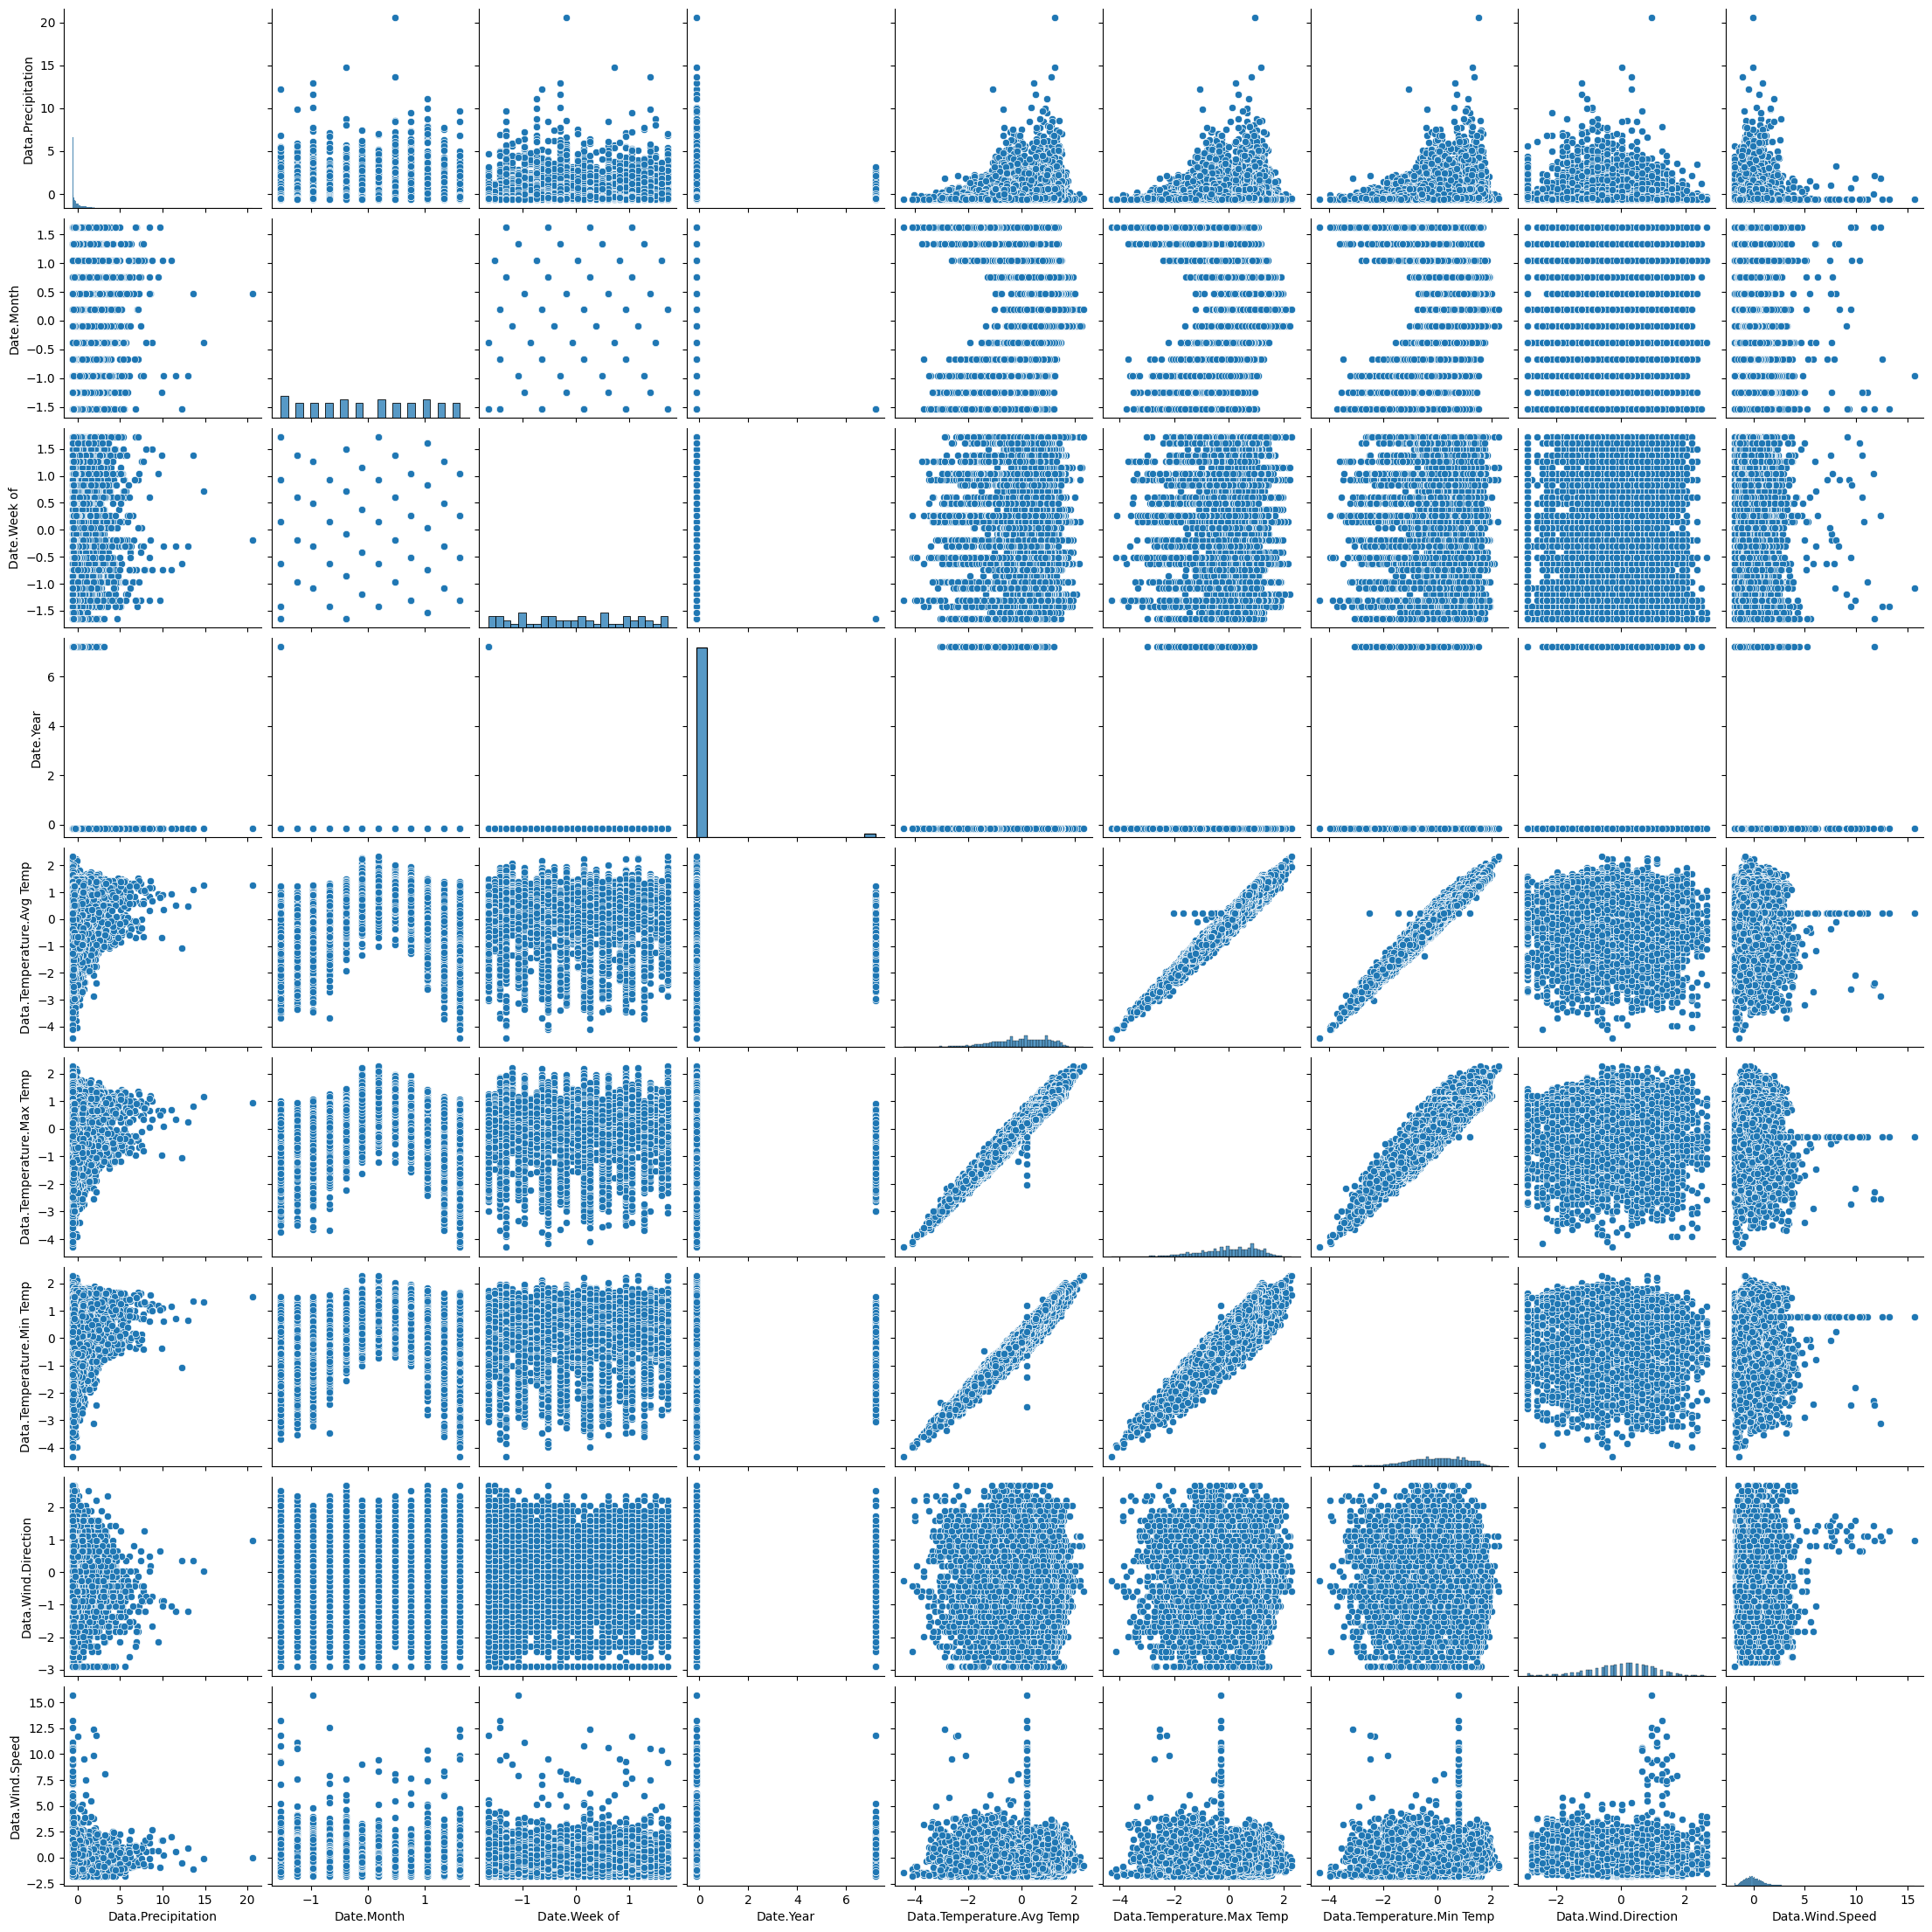

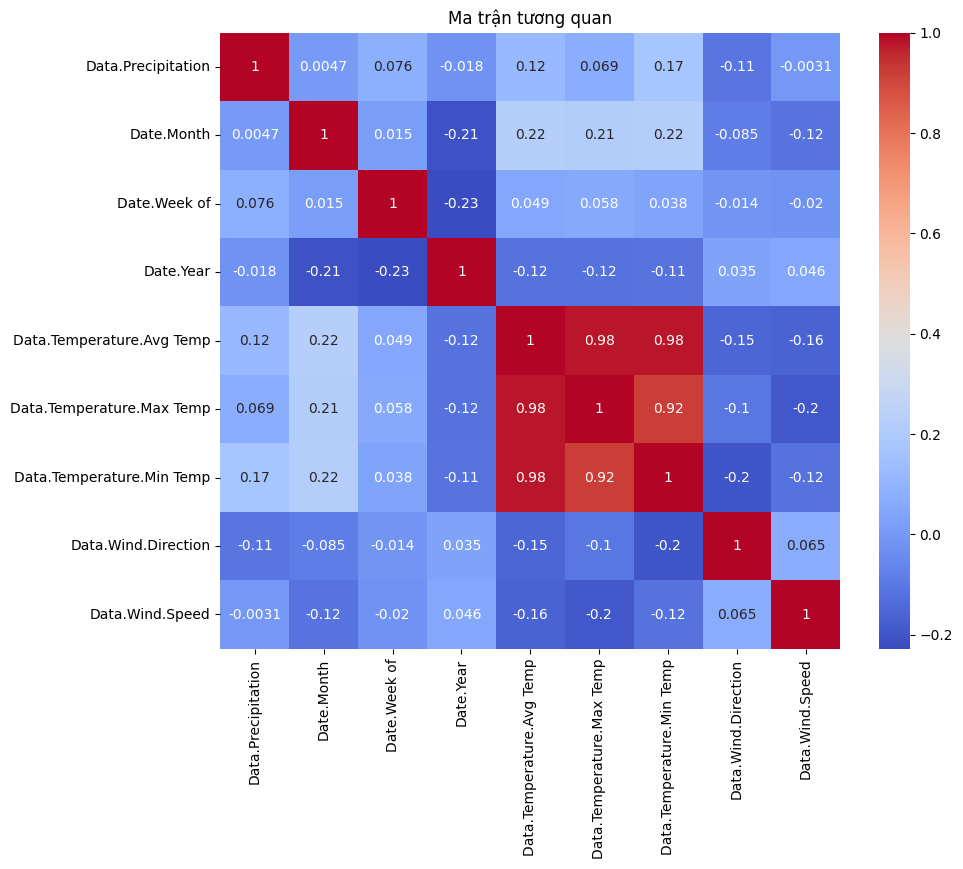

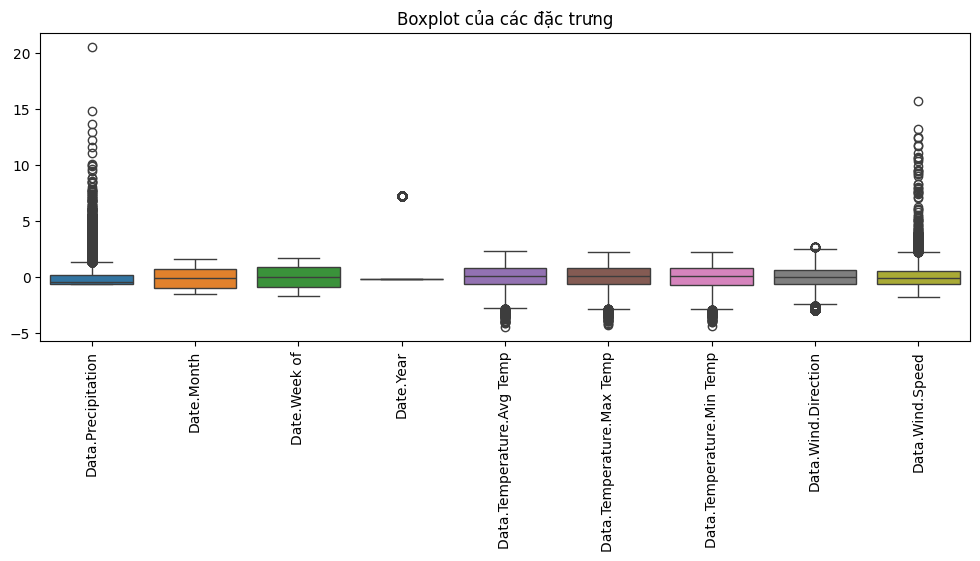

In [20]:
# Bước 3: Trực quan hóa dữ liệu
# Biểu đồ scatter
sns.pairplot(du_lieu)
plt.show()

#  Ma trận tương quan
plt.figure(figsize=(10, 8))
# Only include numerical features for correlation calculation
numerical_du_lieu = du_lieu.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numerical_du_lieu.corr(), annot=True, cmap='coolwarm')
plt.title("Ma trận tương quan")
plt.show()

# Biểu đồ boxplot để kiểm tra outlier
plt.figure(figsize=(12, 4))
sns.boxplot(data=numerical_du_lieu) # Use numerical_du_lieu instead
plt.title("Boxplot của các đặc trưng")
plt.xticks(rotation=90)
plt.show()

Kết quả phân loại:
Độ chính xác: 0.7157360406091371
Ma trận nhầm lẫn:
[[2116  201]
 [ 751  281]]
Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      2317
           1       0.58      0.27      0.37      1032

    accuracy                           0.72      3349
   macro avg       0.66      0.59      0.59      3349
weighted avg       0.69      0.72      0.68      3349



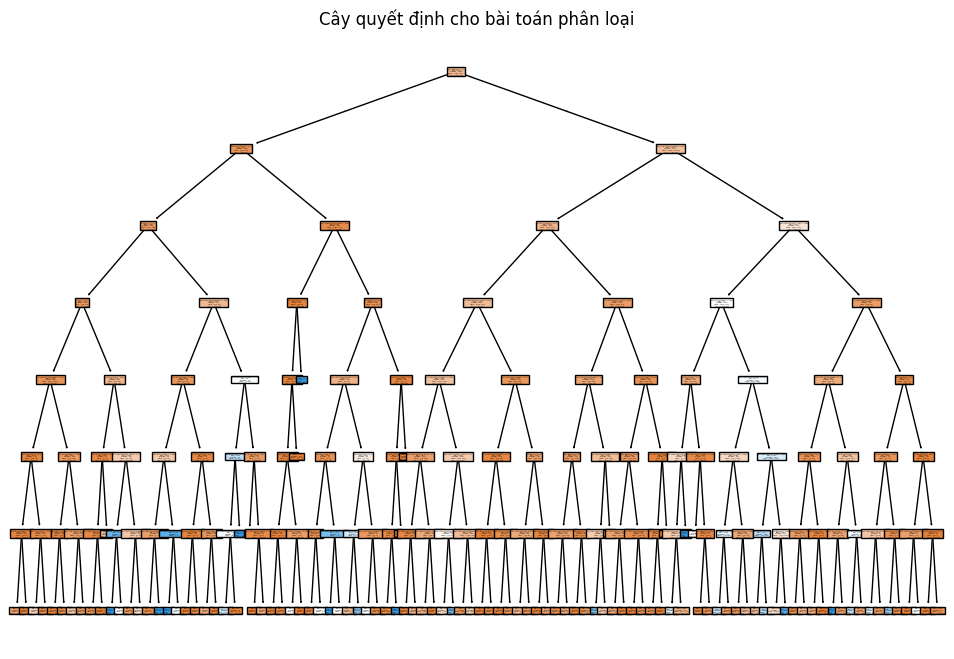

In [11]:
# Bước 4: Huấn luyện mô hình phân loại
# Phân loại (Dự đoán có mưa hay không)
muc_tieu_phan_loai = 'Data.Precipitation'
muc_tieu_hoi_quy = 'Data.Temperature.Avg Temp'

# Kiểm tra nếu các cột tồn tại trong dữ liệu
if muc_tieu_phan_loai not in du_lieu.columns:
    print(f"Cột '{muc_tieu_phan_loai}' không tồn tại trong dữ liệu.")
else:
    X_class = du_lieu.drop(columns=[muc_tieu_phan_loai])
    y_class = du_lieu[muc_tieu_phan_loai]

    # Chuyển cột 'Data.Precipitation' thành nhị phân (1: mưa, 0: không mưa)
    y_class = (y_class > 0).astype(int)  # Giả sử giá trị mưa > 0 sẽ là "mưa" (1), ngược lại là "không mưa" (0)

    # Loại bỏ các cột không phải số
    cac_cot_bo_loai = ['Date.Full', 'Station.City', 'Station.Code', 'Station.Location', 'Station.State']
    X_class = X_class.drop(columns=cac_cot_bo_loai, errors='ignore')

    # Mã hóa các cột phân loại (nếu có)
    X_class = pd.get_dummies(X_class, drop_first=True)

# Kiểm tra nếu dữ liệu đã sẵn sàng cho mô hình phân loại
if 'X_class' in locals() and 'y_class' in locals():
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42
    )

    # Sử dụng GridSearchCV để tìm siêu tham số tối ưu
    param_grid_class = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search_class = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid_class,
        cv=5,
        scoring='accuracy'
    )
    grid_search_class.fit(X_train_class, y_train_class)
    best_classifier = grid_search_class.best_estimator_

    y_du_doan_class = best_classifier.predict(X_test_class)  # Dự đoán cho phân loại

    # Kết quả phân loại
    print("Kết quả phân loại:")
    print("Độ chính xác:", accuracy_score(y_test_class, y_du_doan_class))
    print("Ma trận nhầm lẫn:")
    print(confusion_matrix(y_test_class, y_du_doan_class))
    print("Báo cáo phân loại:")
    print(classification_report(y_test_class, y_du_doan_class))

    plt.figure(figsize=(12, 8))
    plot_tree(best_classifier, feature_names=X_class.columns, class_names=['Không mưa', 'Mưa'], filled=True)
    plt.title("Cây quyết định cho bài toán phân loại")
    plt.savefig('cay_quyet_dinh.svg')
    plt.show()



Kết quả hồi quy:
Sai số bình phương trung bình: 0.0017391303077796726


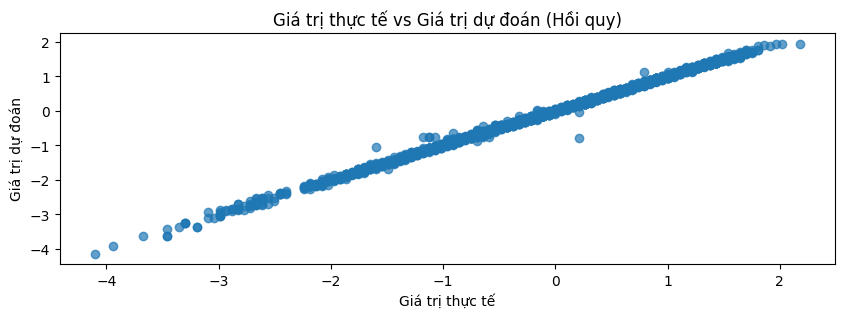

In [18]:
# Huấn luyện mô hình hồi quy
# Hồi quy (Dự đoán nhiệt độ trung bình)
if muc_tieu_hoi_quy not in du_lieu.columns:
    print(f"Cột '{muc_tieu_hoi_quy}' không tồn tại trong dữ liệu.")
else:
    # Tạo X_reg và y_reg cho bài toán hồi quy
    X_reg = du_lieu.drop(columns=[muc_tieu_hoi_quy] + cac_cot_bo_loai, errors='ignore')
    y_reg = du_lieu[muc_tieu_hoi_quy]

    # Chỉ giữ lại các cột số cho X_reg
    X_reg = X_reg.select_dtypes(include=['float64', 'int64'])

    # Tiến hành chia dữ liệu huấn luyện và kiểm tra cho hồi quy
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )

    # Sử dụng GridSearchCV để tìm siêu tham số tối ưu
    param_grid_reg = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search_reg = GridSearchCV(
        DecisionTreeRegressor(random_state=42),
        param_grid_reg,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    grid_search_reg.fit(X_train_reg, y_train_reg)
    best_regressor = grid_search_reg.best_estimator_

    # Dự đoán và đánh giá
    y_du_doan_reg = best_regressor.predict(X_test_reg)

    # Kết quả hồi quy
    print("\nKết quả hồi quy:")
    print("Sai số bình phương trung bình:", mean_squared_error(y_test_reg, y_du_doan_reg))

    plt.figure(figsize=(10, 3))
    plt.scatter(y_test_reg, y_du_doan_reg, alpha=0.7)
    plt.xlabel("Giá trị thực tế")
    plt.ylabel("Giá trị dự đoán")
    plt.title("Giá trị thực tế vs Giá trị dự đoán (Hồi quy)")
    plt.show()

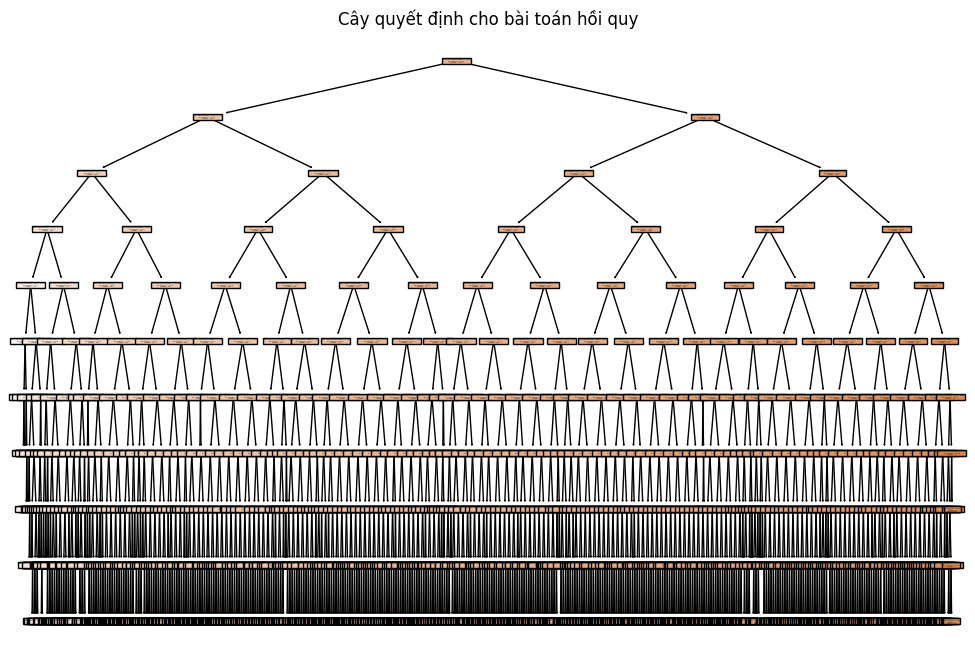

In [19]:
plt.figure(figsize=(12, 8))
plot_tree(best_regressor, feature_names=X_reg.columns, filled=True)
plt.title("Cây quyết định cho bài toán hồi quy")
plt.show()

In [15]:
# So sánh Cart với các model khác
def run_model_comparison(X, y, task_type='classification'):
    # Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Các tham số tinh chỉnh
    if task_type == 'classification':
        models = {
            'Decision Tree': {
                'model': DecisionTreeClassifier(random_state=42),
                'params': {
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5, 10]
                },
                'scoring': 'accuracy'
            },
            'Logistic Regression': {
                'model': LogisticRegression(max_iter=1000, random_state=42),
                'params': {
                    'C': [0.1, 1, 10],
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear', 'saga']
                },
                'scoring': 'accuracy'
            },
            'SVM': {
                'model': SVC(random_state=42),
                'params': {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf']
                },
                'scoring': 'accuracy'
            }
        }
    else:  # regression
        models = {
            'Decision Tree': {
                'model': DecisionTreeRegressor(random_state=42),
                'params': {
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5, 10]
                },
                'scoring': 'neg_mean_squared_error'
            },
            'Linear Regression': {
                'model': LinearRegression(),
                'params': {},  # Không có tham số để tinh chỉnh
                'scoring': 'neg_mean_squared_error'
            },
            'SVR': {
                'model': SVR(),
                'params': {
                    'C': [0.1, 1, 10],
                    'kernel': ['linear', 'rbf']
                },
                'scoring': 'neg_mean_squared_error'
            }
        }

    # Kết quả so sánh
    performance_results = {}

    for name, model_info in models.items():
        # Thực hiện GridSearchCV
        grid_search = GridSearchCV(
            model_info['model'],
            model_info['params'],
            cv=5,
            scoring=model_info['scoring']
        )

        # Đo thời gian huấn luyện
        start_train_time = time.time()
        grid_search.fit(X_train, y_train)
        train_time = time.time() - start_train_time

        # Lấy mô hình tốt nhất
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Đo thời gian dự đoán
        start_predict_time = time.time()
        y_pred = best_model.predict(X_test)
        predict_time = time.time() - start_predict_time

        # Đánh giá mô hình
        if task_type == 'classification':
            performance = {
                'Train Time (s)': train_time,
                'Predict Time (s)': predict_time,
                'Total Time (s)': train_time + predict_time,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Best Params': best_params,
                'Report': classification_report(y_test, y_pred)
            }
        else:  # regression
            performance = {
                'Train Time (s)': train_time,
                'Predict Time (s)': predict_time,
                'Total Time (s)': train_time + predict_time,
                'MSE': mean_squared_error(y_test, y_pred),
                'R-squared': r2_score(y_test, y_pred),
                'Best Params': best_params
            }

        performance_results[name] = performance

    # In kết quả chi tiết
    for model, performance in performance_results.items():
        print(f"\n{model} Performance:")
        for metric, value in performance.items():
            print(f"{metric}: {value}")

    # Trực quan hóa
    plot_model_time_comparison(performance_results, task_type)

def plot_model_time_comparison(performance_results, task_type='classification'):
    # Chuẩn bị dữ liệu
    models = list(performance_results.keys())
    train_times = [result['Train Time (s)'] for result in performance_results.values()]
    predict_times = [result['Predict Time (s)'] for result in performance_results.values()]
    total_times = [result['Total Time (s)'] for result in performance_results.values()]

    # Tạo subplot
    if task_type == 'classification':
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Biểu đồ thời gian
        x = np.arange(len(models))
        width = 0.25

        ax1.bar(x - width, train_times, width, label='Train Time', color='blue')
        ax1.bar(x, predict_times, width, label='Predict Time', color='green')
        ax1.bar(x + width, total_times, width, label='Total Time', color='red')

        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Model Execution Time Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45)
        ax1.legend()

        # Biểu đồ accuracy
        accuracies = [result['Accuracy'] for result in performance_results.values()]
        ax2.bar(models, accuracies, color='purple')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Model Accuracy Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(models, rotation=45)

    else:  # Regression
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

        # Biểu đồ thời gian
        x = np.arange(len(models))
        width = 0.25

        ax1.bar(x - width, train_times, width, label='Train Time', color='blue')
        ax1.bar(x, predict_times, width, label='Predict Time', color='green')
        ax1.bar(x + width, total_times, width, label='Total Time', color='red')

        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Model Execution Time Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, rotation=45)
        ax1.legend()

        # Biểu đồ R-squared
        r2_values = [result['R-squared'] for result in performance_results.values()]
        ax2.bar(models, r2_values, color='salmon')
        ax2.set_ylabel('R-squared')
        ax2.set_title('Model R-squared Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(models, rotation=45)

        # Biểu đồ MSE
        mse_values = [result['MSE'] for result in performance_results.values()]
        ax3.bar(models, mse_values, color='green')
        ax3.set_ylabel('MSE')
        ax3.set_title('Model MSE Comparison')
        ax3.set_xticks(x)
        ax3.set_xticklabels(models, rotation=45)

    plt.tight_layout()
    plt.show()


Decision Tree Performance:
Train Time (s): 1.2156307697296143
Predict Time (s): 0.0017490386962890625
Total Time (s): 1.2173798084259033
Accuracy: 0.7154374440131382
Best Params: {'max_depth': 7, 'min_samples_split': 5}
Report:               precision    recall  f1-score   support

           0       0.74      0.91      0.82      2317
           1       0.58      0.27      0.37      1032

    accuracy                           0.72      3349
   macro avg       0.66      0.59      0.59      3349
weighted avg       0.69      0.72      0.68      3349


Logistic Regression Performance:
Train Time (s): 18.062331438064575
Predict Time (s): 0.001661062240600586
Total Time (s): 18.063992500305176
Accuracy: 0.6810988354732757
Best Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Report:               precision    recall  f1-score   support

           0       0.70      0.93      0.80      2317
           1       0.43      0.11      0.18      1032

    accuracy                         

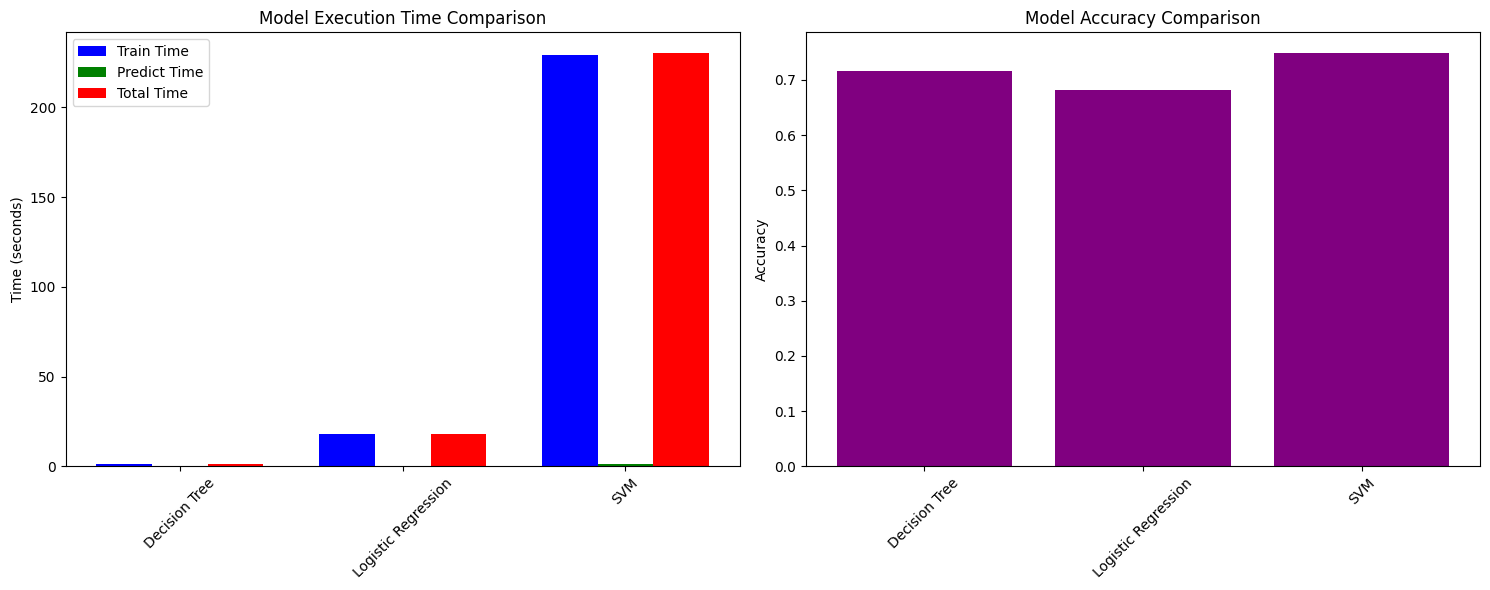

In [16]:
run_model_comparison(X_class, y_class, 'classification')


Decision Tree Performance:
Train Time (s): 1.2615830898284912
Predict Time (s): 0.001894235610961914
Total Time (s): 1.2634773254394531
MSE: 0.003922228302345905
R-squared: 0.9961039719432747
Best Params: {'max_depth': 7, 'min_samples_split': 2}

Linear Regression Performance:
Train Time (s): 0.13105320930480957
Predict Time (s): 0.0054209232330322266
Total Time (s): 0.1364741325378418
MSE: 0.0008846363493842064
R-squared: 0.9991212729674256
Best Params: {}

SVR Performance:
Train Time (s): 36.90833854675293
Predict Time (s): 0.012547016143798828
Total Time (s): 36.92088556289673
MSE: 0.0013070241328803354
R-squared: 0.9987017067085378
Best Params: {'C': 1, 'kernel': 'linear'}


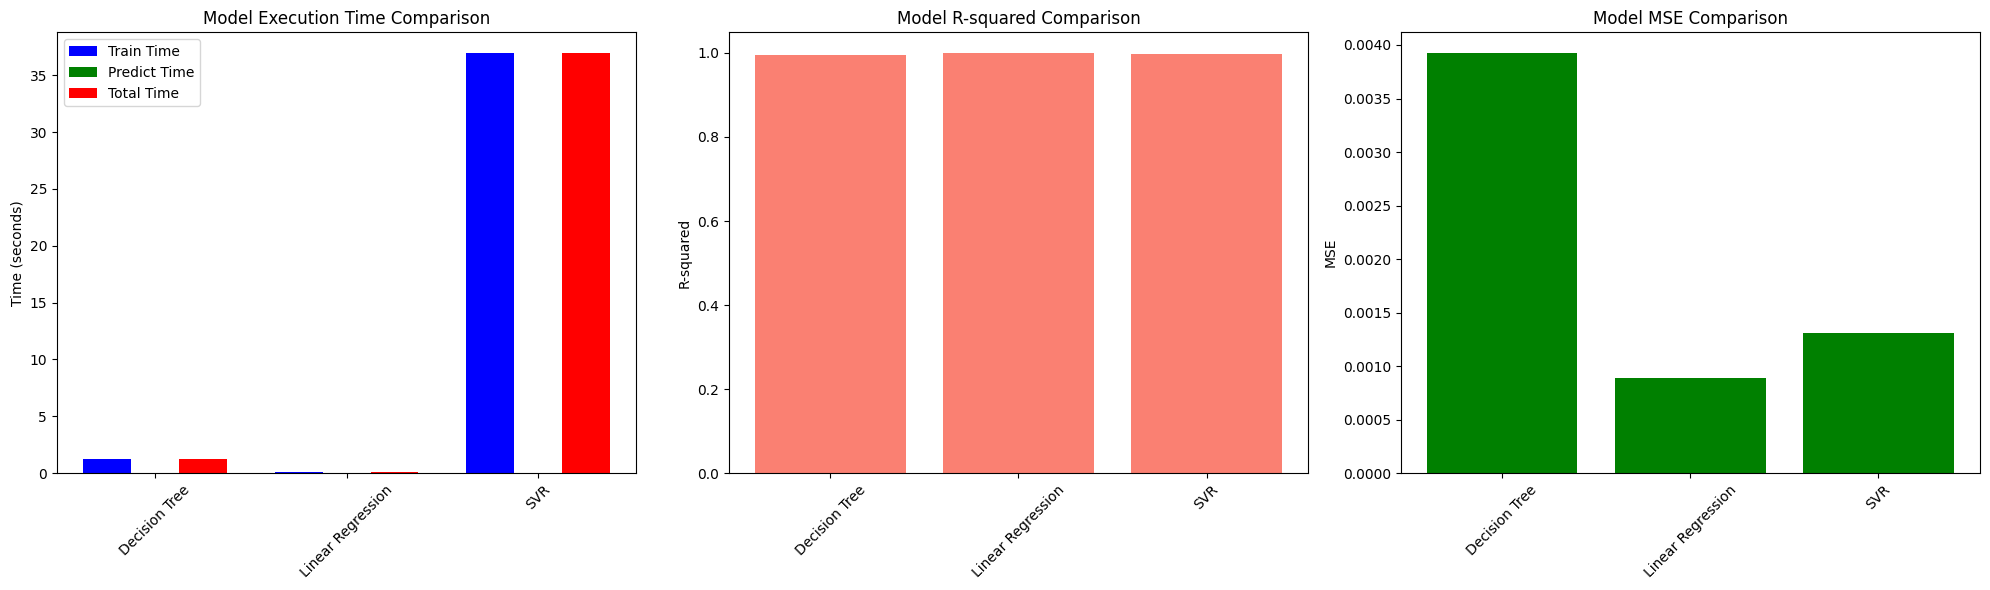

In [ ]:
run_model_comparison(X_reg, y_reg, 'regression')